In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
from careamics import Configuration, CAREamist

sys.path.append(str(Path("..").resolve()))
from src import *

Cupy Available= 0


# Noise2Void Training
Let's try out some pupolar SOTA denoisers. In this experiment I will rely of [*CAREamics*](https://careamics.github.io) implementation, that is built with *PyThorch*, in contrast to the original [*Noise2Noise*](https://github.com/NVlabs/noise2noise), which uses *TensorFlow*.

In [ ]:
WORK_DIR=Path("n2v")
x_path = DATASETS["synthetic"].dir / "noise_1Q_-5.52dBSNR_490x490x6000.tif"
gt_path = DATASETS["synthetic"].dir / "clean_30Hz_490x490x6000.tif"
x, gt = (Recording(_, max_frames=600) for _ in [x_path, gt_path])

In [ ]:
config_dict = {
    "experiment_name": "N2V_synthetic",
    "algorithm_config": {
        "algorithm": "n2v",
        "loss": "n2v",
        "model": {
            "architecture": "UNet",
            # "num_channels":[64, 128, 256],
        },
    },
    "training_config": {
        "batch_size": 16,
        "num_epochs":10,
        "learning_rate": 0.0004,
    },
    "data_config": {
        "data_type": "array",
        "axes": "TYX",
        "patch_size": [128, 128],  # Noise2Void doesnt exploit temporal dim
    },
}
cfg = Configuration(**config_dict)

In [ ]:
engine = CAREamist(cfg)
cprint("cyan:Starting N2V training...")
history = engine.train(train_source=x.np)

In [ ]:
engine = CAREamist("checkpoints/N2V_synthetic-v5.ckpt")
y=engine.predict(x.np[:,:488,:488])
y=np.stack([frame.squeeze().squeeze() for frame in y])

No working directory provided. Using current working directory: /run/media/Windows11/Users/MrPio/Desktop/Ide Projects/PycharmProjects/CalciumImagingDenoising/2-denoise.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/run/media/Windows11/Users/MrPio/Desktop/Ide Projects/PycharmProjects/CalciumImagingDenoising/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



Predicting: |          | 0/? [00:00<?, ?it/s]

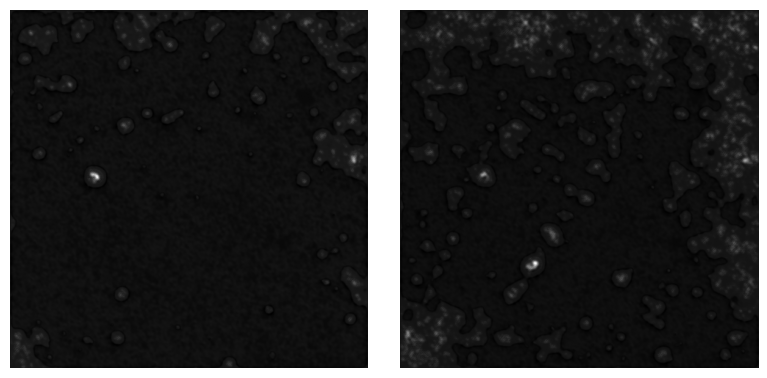

In [8]:
imshow([y[i] for i in [0,-1]])

In [ ]:
Recording(y[:60]).render("n2v.mp4", codec="libx264")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (488, 488) to (496, 496) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
